## Setup PySpark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression

## Init Spark

In [3]:
spark = SparkSession.builder.appName("BitcoinPricePrediction").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/09 14:57:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load Data

In [4]:
from elasticsearch import Elasticsearch

es = Elasticsearch(hosts=["http://localhost:9200"])

response = es.search(index="historical", body={
    "query": {
        "match_all": {}
    },
    "size": 1000  
})

data = [hit["_source"] for hit in response["hits"]["hits"]]

spark = SparkSession.builder.appName("BitcoinPricePrediction").getOrCreate()

training_df = spark.createDataFrame(data)

## Feature Engineering lag 


In [5]:
window_spec = Window.orderBy("time_numeric")

training_df = training_df.withColumn("BTC_lag_1", lag("BTC_close", 1).over(window_spec))
training_df = training_df.withColumn("BTC_lag_3", lag("BTC_close", 3).over(window_spec))
training_df = training_df.withColumn("ETH_lag_1", lag("ETH_close", 1).over(window_spec))
training_df = training_df.withColumn("ETH_lag_3", lag("ETH_close", 3).over(window_spec))

training_df = training_df.na.drop()

## Split Data

##### For time series models (such as Bitcoin predictions), randomSplit() is not ideal because future values are not randomly distributed. Instead, a rolling split should be used so that the model learns only from past data.

In [6]:
training_df = training_df.orderBy("time_numeric")
split_index = int(training_df.count() * 0.8)
train_data = training_df.limit(split_index)
test_data = training_df.subtract(train_data)

print(f"Train: {train_data.count()} rows, Test: {test_data.count()} rows")

Train: 797 rows, Test: 200 rows


## Vectorize features

In [7]:
feature_cols = ["BTC_ETH_ratio",  "BTC_price_change" , "BTC_volatility", "BTC_volume", "ETH_close", "ETH_price_change", "ETH_volatility", "ETH_volume", "BTC_lag_1", "BTC_lag_3", "ETH_lag_1", "ETH_lag_3"]
featureassembler = VectorAssembler(inputCols=feature_cols,outputCol="independent_features")
train_data = featureassembler.transform(train_data)
test_data = featureassembler.transform(test_data)
print(train_data.show(5))

+------------------+---------+--------------------+------------------+----------+---------+--------------------+------------------+----------+------------+-------------------+---------+---------+---------+---------+--------------------+
|     BTC_ETH_ratio|BTC_close|    BTC_price_change|    BTC_volatility|BTC_volume|ETH_close|    ETH_price_change|    ETH_volatility|ETH_volume|time_numeric|          timestamp|BTC_lag_1|BTC_lag_3|ETH_lag_1|ETH_lag_3|independent_features|
+------------------+---------+--------------------+------------------+----------+---------+--------------------+------------------+----------+------------+-------------------+---------+---------+---------+---------+--------------------+
| 35.13585382983603| 98054.33|9.387277992560783E-4|  91.9600000000064|   0.23132|  2790.72|0.001112059749894...| 3.099999999999909|     5.402|  1738760760|2025-02-05T13:06:00| 97962.37| 97978.95|  2787.62|  2787.42|[35.1358538298360...|
| 35.12933993564892| 98043.88|-1.06573569979007...| 

## Normalize Features

In [8]:
scaler = MinMaxScaler(inputCol="independent_features", outputCol="scaled_features")
scaler_model = scaler.fit(train_data)

train_data = scaler_model.transform(train_data)
test_data = scaler_model.transform(test_data)

train_data.show(2, truncate=False)
test_data.show(2, truncate=False)

+-----------------+---------+----------------------+----------------+----------+---------+---------------------+------------------+----------+------------+-------------------+---------+---------+---------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|BTC_ETH_ratio    |BTC_close|BTC_price_change      |BTC_volatility  |BTC_volume|ETH_close|ETH_price_change     |ETH_volatility    |ETH_volume|time_numeric|timestamp          |BTC_lag_1|BTC_lag_3|ETH_lag_1|ETH_lag_3|independent_features                                                                                                                                       |scaled_features         

In [9]:
finalized_train_data_output = train_data.select("scaled_features","BTC_close")
print(finalized_train_data_output.show(5))

+--------------------+---------+
|     scaled_features|BTC_close|
+--------------------+---------+
|[0.94262651739845...| 98054.33|
|[0.94240528649449...| 98043.88|
|[0.94231836193188...| 98073.62|
|[0.94040251698131...|  98053.6|
|[0.94211262476878...| 98165.23|
+--------------------+---------+
only showing top 5 rows

None


## Train Model

In [10]:
from pyspark.ml.regression import LinearRegression

regressor = LinearRegression(featuresCol="scaled_features", labelCol="BTC_close")
regressor = regressor.fit(finalized_train_data_output)


In [12]:
from sklearn.linear_model import LinearRegression as SklearnLR
import joblib
import numpy as np

coefficients = regressor.coefficients.toArray()  
intercept = regressor.intercept                  

sklearn_model = SklearnLR()
sklearn_model.coef_ = np.array(coefficients)  
sklearn_model.intercept_ = intercept          

joblib.dump(sklearn_model, "regression/crypto_model.joblib")
print("Modell erfolgreich mit joblib gespeichert!")

Modell erfolgreich mit joblib gespeichert!


In [11]:
predictions = regressor.transform(test_data)

In [12]:
predictions.show(10)

+------------------+---------+--------------------+------------------+----------+---------+--------------------+------------------+----------+------------+-------------------+---------+---------+---------+---------+--------------------+--------------------+------------------+
|     BTC_ETH_ratio|BTC_close|    BTC_price_change|    BTC_volatility|BTC_volume|ETH_close|    ETH_price_change|    ETH_volatility|ETH_volume|time_numeric|          timestamp|BTC_lag_1|BTC_lag_3|ETH_lag_1|ETH_lag_3|independent_features|     scaled_features|        prediction|
+------------------+---------+--------------------+------------------+----------+---------+--------------------+------------------+----------+------------+-------------------+---------+---------+---------+---------+--------------------+--------------------+------------------+
| 31.20574822646554|102712.16|                 0.0|12.839999999996508|     0.001|  3291.45|-0.00733764001230...|25.550000000000182|    0.0824|  1737354660|2025-01-20T06:

In [13]:
from pyspark.ml.evaluation import RegressionEvaluator

# Mean Absolute Error (MAE)
evaluator_mae = RegressionEvaluator(labelCol="BTC_close", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

# Root Mean Squared Error (RMSE)
evaluator_rmse = RegressionEvaluator(labelCol="BTC_close", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

# R-squared (R²)
evaluator_r2 = RegressionEvaluator(labelCol="BTC_close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

# Display results
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 540.9364086765158
RMSE: 696.6081724404379
R²: 0.9025110387098105


             timestamp  BTC_close     prediction
0  2025-01-19T17:14:00  104601.45  104299.210540
1  2025-01-19T17:15:00  104452.30  104164.944952


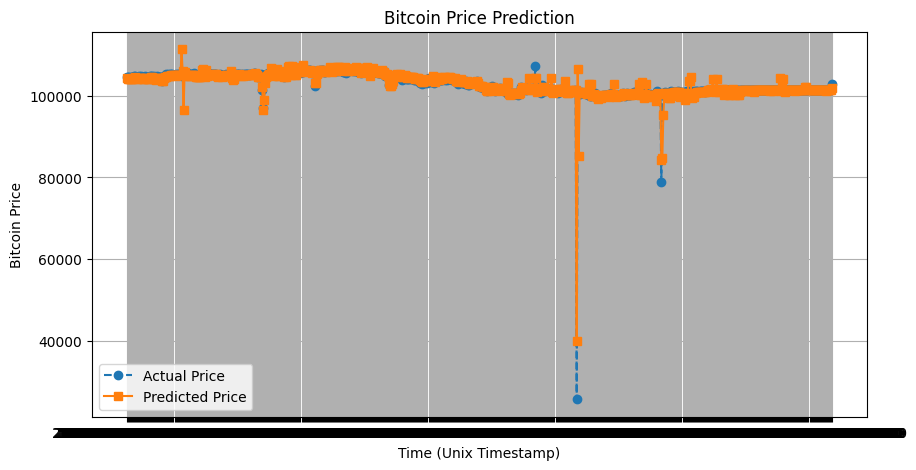

In [16]:
import matplotlib.pyplot as plt

predictions = regressor.transform(train_data)

pdf = predictions.select("timestamp", "BTC_close", "prediction").toPandas().head(700)

print(pdf.head(2))

plt.figure(figsize=(10, 5))
plt.plot(pdf["timestamp"], pdf["BTC_close"], label="Actual Price", marker="o", linestyle="dashed")
plt.plot(pdf["timestamp"], pdf["prediction"], label="Predicted Price", marker="s", linestyle="solid")

plt.xlabel("Time (Unix Timestamp)")
plt.ylabel("Bitcoin Price")
plt.title("Bitcoin Price Prediction")
plt.legend()
plt.grid()
plt.show()

In [17]:
pdf["signal"] = pdf["prediction"] > pdf["BTC_close"]

pdf["profit"] = pdf["BTC_close"].diff() * pdf["signal"].shift(1).fillna(0)

print(pdf.head(5))

total_earnings = pdf["profit"].sum()

print(total_earnings)

             timestamp  BTC_close     prediction  signal profit
0  2025-01-19T17:14:00  104601.45  104299.210540   False    NaN
1  2025-01-19T17:15:00  104452.30  104164.944952   False   -0.0
2  2025-01-19T17:16:00  104452.30  104070.486469   False    0.0
3  2025-01-19T17:17:00  104345.07  104081.462301   False   -0.0
4  2025-01-19T17:18:00  104601.45  104080.022204   False    0.0
29330.129999999932


In [ ]:
#regressor.write().overwrite().save("regression/crypto_model")

In [13]:
spark.stop()